# Data Pipeline

This notebook describes the pipeline for milestone 3 for our project. It should give an overview of how we intend to load, clean, parse and exploit our data for our story telling.

## Imports

In [1]:
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.cluster.hierarchy import linkage,dendrogram,fcluster
from collections import defaultdict

# Loading and cleaning the data

Given the data size, pandas dataframe will be used.

## Handling data

In [2]:
CHARACTER_DATA_PATH = "./data/character.metadata.tsv"
MOVIE_DATA_PATH = "./data/movie.metadata.tsv"
SUMMARIES_DATA_PATH = "./data/plot_summaries.txt"
NAME_DATA_PATH = "./data/name.clusters.txt"
TYPE_DATA_PATH = "./data/tvtropes.clusters.txt"

## Characters data

In [3]:
CHARACTER_HEADER = [
    "Wikipedia_movie_ID",
    "Freebase_movie_ID",
    "Movie_release_date",
    "Character_name",
    "Actor_date_of_birth",
    "Actor_gender",
    "Actor_height",
    "Actor_ethnicity",
    "Actor_name",
    "Actor_age_at_movie_release",
    "Freebase_character/actor_map_ID",
    "Freebase_character_ID",
    "Freebase_actor_ID",
]
character = pd.read_table(CHARACTER_DATA_PATH, header=None, names=CHARACTER_HEADER)

In [4]:
character.describe()

,Wikipedia_movie_ID,Actor_height,Actor_age_at_movie_release
count,4.506690e+05,154824.000000,292556.000000
mean,1.396975e+07,1.788893,37.788523
std,1.079662e+07,4.379940,20.587870
min,3.300000e+02,0.610000,-7896.000000
25%,3.759292e+06,1.676400,28.000000
50%,1.189065e+07,1.750000,36.000000
75%,2.366501e+07,1.830000,47.000000
max,3.750192e+07,510.000000,103.000000


First, we want to clean the dataset :
- negative ages should be removed
- actor's height > 2.5 as well, as they become irrelevant compared to the true height of actors
- dates converted to correct format

In [5]:
character["Actor_age_at_movie_release"] = character["Actor_age_at_movie_release"].apply(
    lambda x: np.nan if x < 0 else x
)
character["Actor_height"] = character["Actor_height"].apply(
    lambda x: np.nan if x > 2.5 else x
)
character["Movie_release_date"] = pd.to_datetime(
    character["Movie_release_date"], format="mixed", utc=True, errors="coerce"
)
character["Actor_date_of_birth"] = pd.to_datetime(
    character["Actor_date_of_birth"], format="mixed", utc=True, errors="coerce"
)
character.sample(5)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID
3623,6839059,/m/0grynb,1984-11-01 00:00:00+00:00,NaN,1934-12-28 00:00:00+00:00,F,1.651,/m/02w7gg,Maggie Smith,NaN,/m/02vczsl,NaN,/m/0l6px
271468,13851011,/m/02x074v,2007-10-02 00:00:00+00:00,NaN,1987-10-15 00:00:00+00:00,F,NaN,NaN,Chantal Strand,19.0,/m/09vlk3w,NaN,/m/07gl2p
357196,27117697,/m/0br_h56,2010-04-26 00:00:00+00:00,NaN,1955-01-21 00:00:00+00:00,F,NaN,NaN,Leslie Hoffman,55.0,/m/0c1nkqk,NaN,/m/0c1nkp2
398884,12629555,/m/02wyssv,1947-12-27 00:00:00+00:00,NaN,1905-01-17 00:00:00+00:00,M,1.910,NaN,Grant Withers,42.0,/m/0cs80bx,NaN,/m/0fj_nl
359165,18640305,/m/0408m53,2008-08-22 00:00:00+00:00,Lilly,1986-07-09 00:00:00+00:00,F,1.670,/m/0x67,Kiely Williams,22.0,/m/04dgw58,/m/0c1hqmm,/m/05j644


## TODO
Should modify the ethnicityto give corresponding freebase ID. https://pypi.org/project/freebase/

### Movies data

In [6]:
MOVIE_HEADER = [
    "Wikipedia_movie_ID",
    "Freebase_movie_ID",
    "Movie_name",
    "Movie_release_date",
    "Movie_box_office_revenue",
    "Movie_runtime",
    "Movie_languages",
    "Movie_countries",
    "Movie_genres",
]

movie = pd.read_table(MOVIE_DATA_PATH, header=None, names=MOVIE_HEADER)

In [7]:
movie.describe()

,Wikipedia_movie_ID,Movie_box_office_revenue,Movie_runtime
count,8.174100e+04,8.401000e+03,6.129100e+04
mean,1.740784e+07,4.799363e+07,1.118192e+02
std,1.098791e+07,1.121753e+08,4.360070e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,7.323695e+06,2.083193e+06,8.100000e+01
50%,1.777899e+07,1.063969e+07,9.300000e+01
75%,2.715573e+07,4.071696e+07,1.060000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


The next cell will transform the dictionaries we might find in the cells of our data frames into comma-separated strings.

In [8]:
def format_dict(x):
    n = len(x)
    if n == 0:
        return np.nan
    else:
        return list(x.values())


try:
    movie["Movie_genres"] = movie["Movie_genres"].apply(json.loads).apply(format_dict)
    movie["Movie_countries"] = (
        movie["Movie_countries"].apply(json.loads).apply(format_dict)
    )
    movie["Movie_languages"] = (
        movie["Movie_languages"].apply(json.loads).apply(format_dict)
    )
except TypeError:
    print("Data has already been parsed and modified.")

There is a bit of cleaning to perform :
- we will focus on movies whose runtime is < 15000, because that is the longest movie we found to have its true length.
- dates to correct format

In [9]:
movie["Movie_runtime"] = movie["Movie_runtime"].apply(
    lambda x: np.nan if 1 > x or x > 15000 else x
)
movie["Movie_release_date"] = pd.to_datetime(
    movie["Movie_release_date"], format="mixed", utc=True, errors="coerce"
)
movie.sample(5)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
64343,23666609,/m/06zr0_s,"Nudo, crudo e...",1965-01-01 00:00:00+00:00,NaN,NaN,[Italian Language],[Italy],[Documentary]
62983,36194628,/m/04j1wkf,The Killer Must Kill Again,1975-01-01 00:00:00+00:00,NaN,90.0,[Italian Language],[Italy],"[Thriller, Horror, World cinema, Psychological..."
27537,5846648,/m/0f8s67,Tiresia,2003-01-01 00:00:00+00:00,NaN,118.0,"[French Language, Portuguese Language]","[France, Canada]","[LGBT, Thriller, Art film, World cinema, Drama..."
71382,274703,/m/01p5ct,A Medal for Benny,1945-01-01 00:00:00+00:00,NaN,77.0,NaN,[United States of America],[Drama]
4277,19524001,/m/04mz0n2,Sju svarta be-hå,1954-03-22 00:00:00+00:00,NaN,90.0,[Swedish Language],[Sweden],"[Crime Fiction, Black-and-white]"


In [10]:
movie.describe()

,Wikipedia_movie_ID,Movie_box_office_revenue,Movie_runtime
count,8.174100e+04,8.401000e+03,61233.000000
mean,1.740784e+07,4.799363e+07,94.298795
std,1.098791e+07,1.121753e+08,91.294848
min,3.300000e+02,1.000000e+04,1.000000
25%,7.323695e+06,2.083193e+06,81.000000
50%,1.777899e+07,1.063969e+07,93.000000
75%,2.715573e+07,4.071696e+07,106.000000
max,3.750192e+07,2.782275e+09,14400.000000


## Summaries data

In [11]:
summaries = pd.read_table(
    SUMMARIES_DATA_PATH, header=None, names=["Wikipedia_movie_ID", "Summary"]
)
summaries.head()

,Wikipedia_movie_ID,Summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


## Character names data

In [12]:
name = pd.read_table(
    NAME_DATA_PATH,
    header=None,
    names=["Character_name", "Freebase_character/actor_map_ID"],
)
name.head()

,Character_name,Freebase_character/actor_map_ID
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn


## Character types data

In [13]:
character_type = pd.read_table(
    TYPE_DATA_PATH, header=None, names=["Character_type", "Instance"]
)
character_type = pd.concat(
    [character_type, character_type["Instance"].apply(json.loads).apply(pd.Series)],
    axis=1,
)
character_type.drop(columns="Instance", inplace=True)
character_type.rename(
    columns={
        "char": "Character_name",
        "movie": "Movie_name",
        "id": "Freebase_character/actor_map_ID",
        "actor": "Actor_name",
    },
    inplace=True,
)
character_type.head()

,Character_type,Character_name,Movie_name,Freebase_character/actor_map_ID,Actor_name
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


# Visualizing data

Here a few visualiztions are provided to get a glimpse of the data.

## Characters dataset

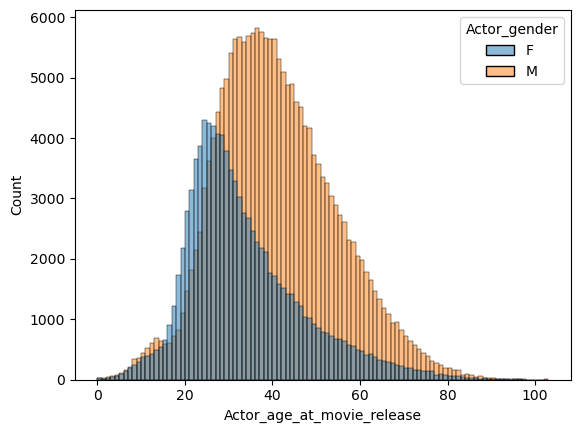

In [14]:
sns.histplot(
    data=character, x="Actor_age_at_movie_release", hue="Actor_gender", binwidth=1
)

(1.4, 2.1)

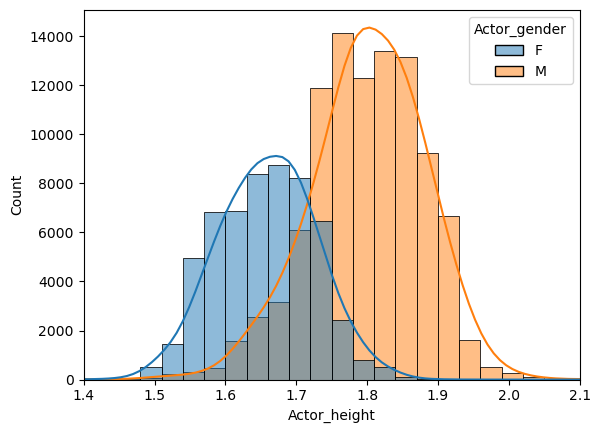

In [15]:
sns.histplot(
    data=character,
    x="Actor_height",
    hue="Actor_gender",
    binwidth=0.03,
    kde=True,
    kde_kws={"bw_adjust": 3},
)
plt.xlim([1.4, 2.1])

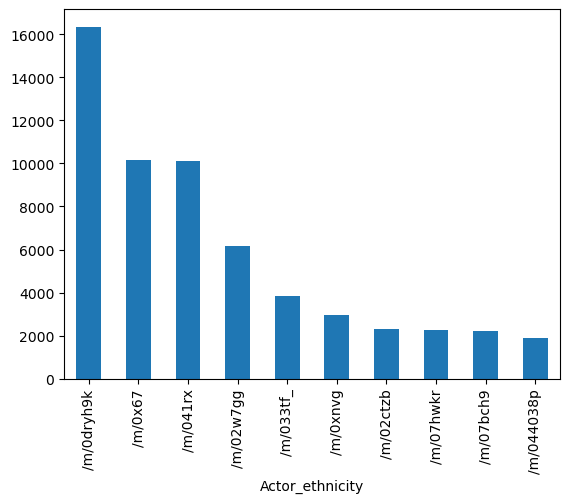

In [16]:
character["Actor_ethnicity"].value_counts().head(10).plot(kind="bar")

## Movies dataset

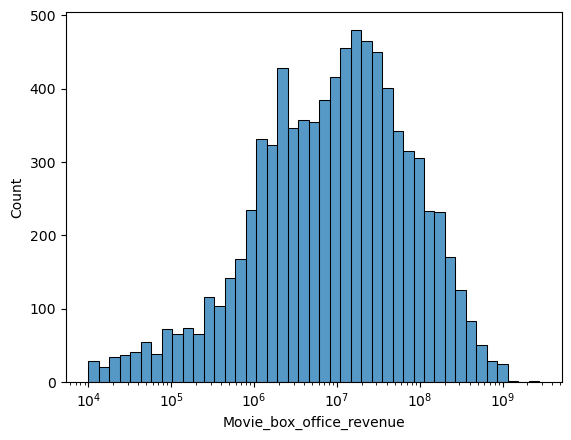

In [17]:
sns.histplot(data=movie, x="Movie_box_office_revenue", log_scale=True)

The spike around $ 1 million is weird, must be investigated.

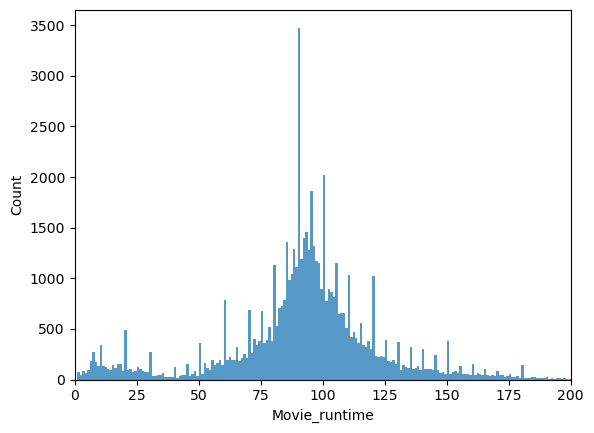

In [18]:
sns.histplot(data=movie, x="Movie_runtime", binwidth=1)
plt.xlim([0, 200])

- Lots of movie of 90 min

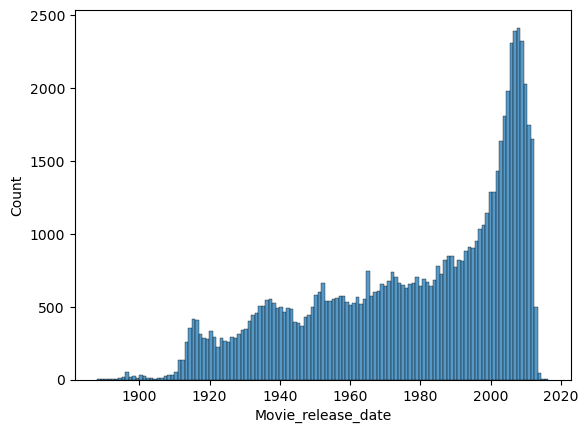

In [19]:
sns.histplot(
    data=movie,
    x="Movie_release_date",
    bins=(max(movie.Movie_release_date).year - min(movie.Movie_release_date).year + 1),
)

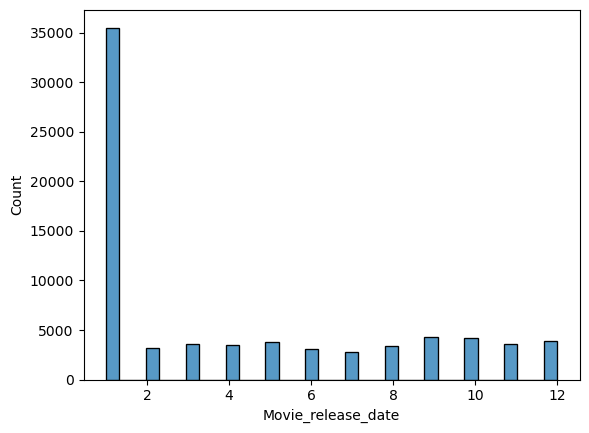

In [20]:
sns.histplot(movie["Movie_release_date"].apply(lambda x: x.month))

- Because of `pd.to_datetime` which converts to the first day of the year a date with only the year indicated
- If monthly or daily analysis wanted, use `format = "%Y-%m-%d"`as argument of `pd.to_datetime`

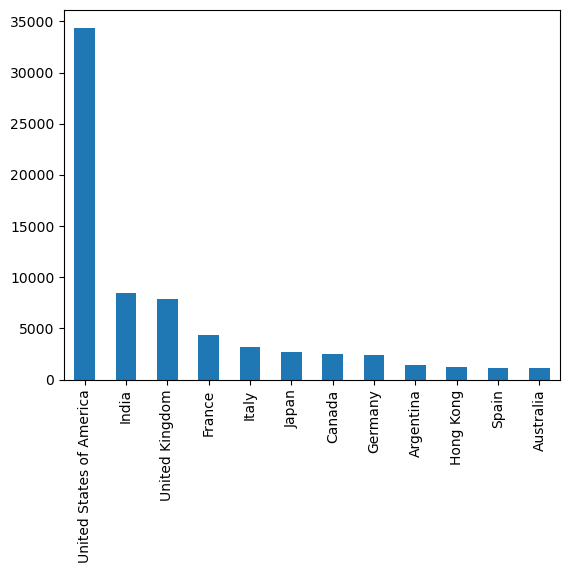

In [21]:
movie_countries = (
    movie["Movie_countries"]
    .apply(lambda x: pd.Series(x).value_counts())
    .sum()
    .sort_values(ascending=False)
)
movie_countries.loc[movie_countries.values >= 1000].plot(kind="bar")

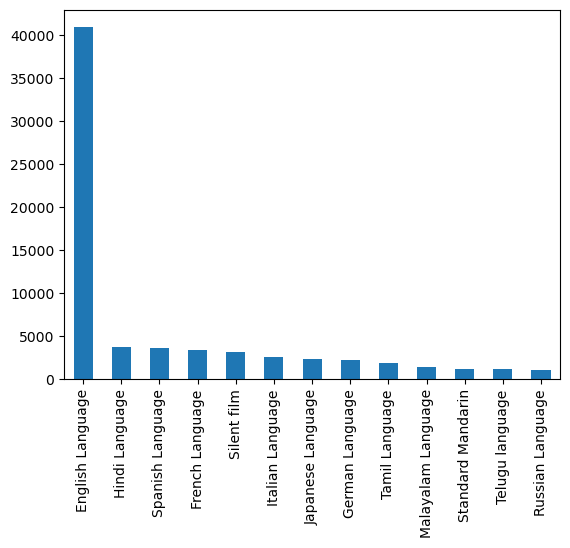

In [22]:
movie_language = (
    movie["Movie_languages"]
    .apply(lambda x: pd.Series(x).value_counts())
    .sum()
    .sort_values(ascending=False)
)
movie_language.loc[movie_language.values >= 1000].plot(kind="bar")

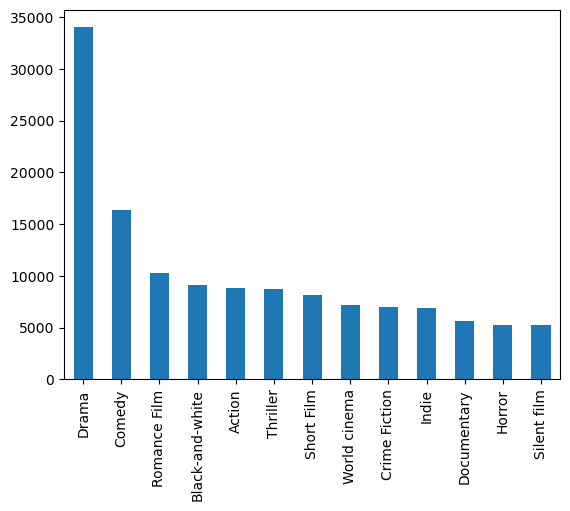

In [23]:
movie_genres = (
    movie["Movie_genres"]
    .apply(lambda x: pd.Series(x).value_counts())
    .sum()
    .sort_values(ascending=False)
)
movie_genres.loc[movie_genres.values >= 5000].plot(kind="bar")

## Names of characters dataset

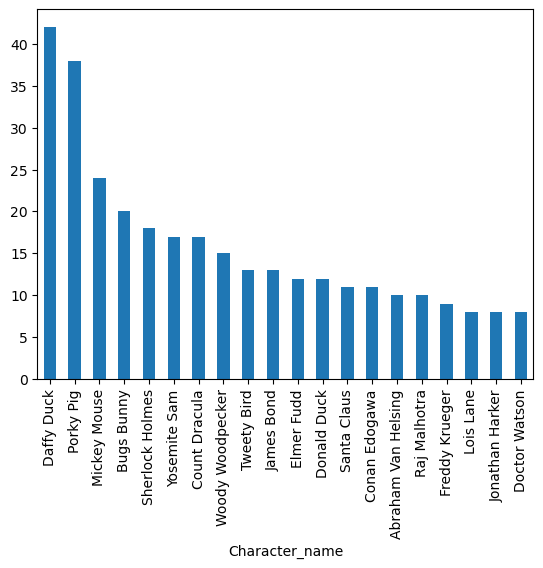

In [24]:
name["Character_name"].value_counts().head(20).plot(kind="bar")

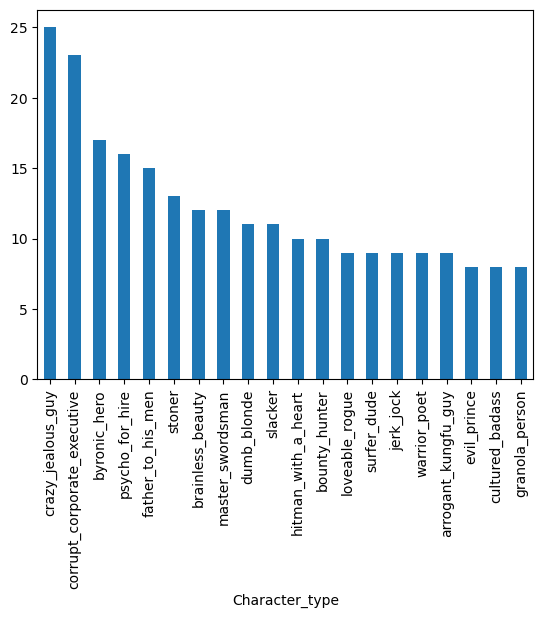

In [25]:
character_type["Character_type"].value_counts().head(20).plot(kind="bar")

# Data processing pipeline and story telling

The purpose of the data gathering is to tell a story. 

## Genres analysis

First, to analys the genres with have to summarize the 363 different genres that with have in the `Movie_genres` column of the `movie` dataframe.

A naive approach would be to direct do a clustering as below.

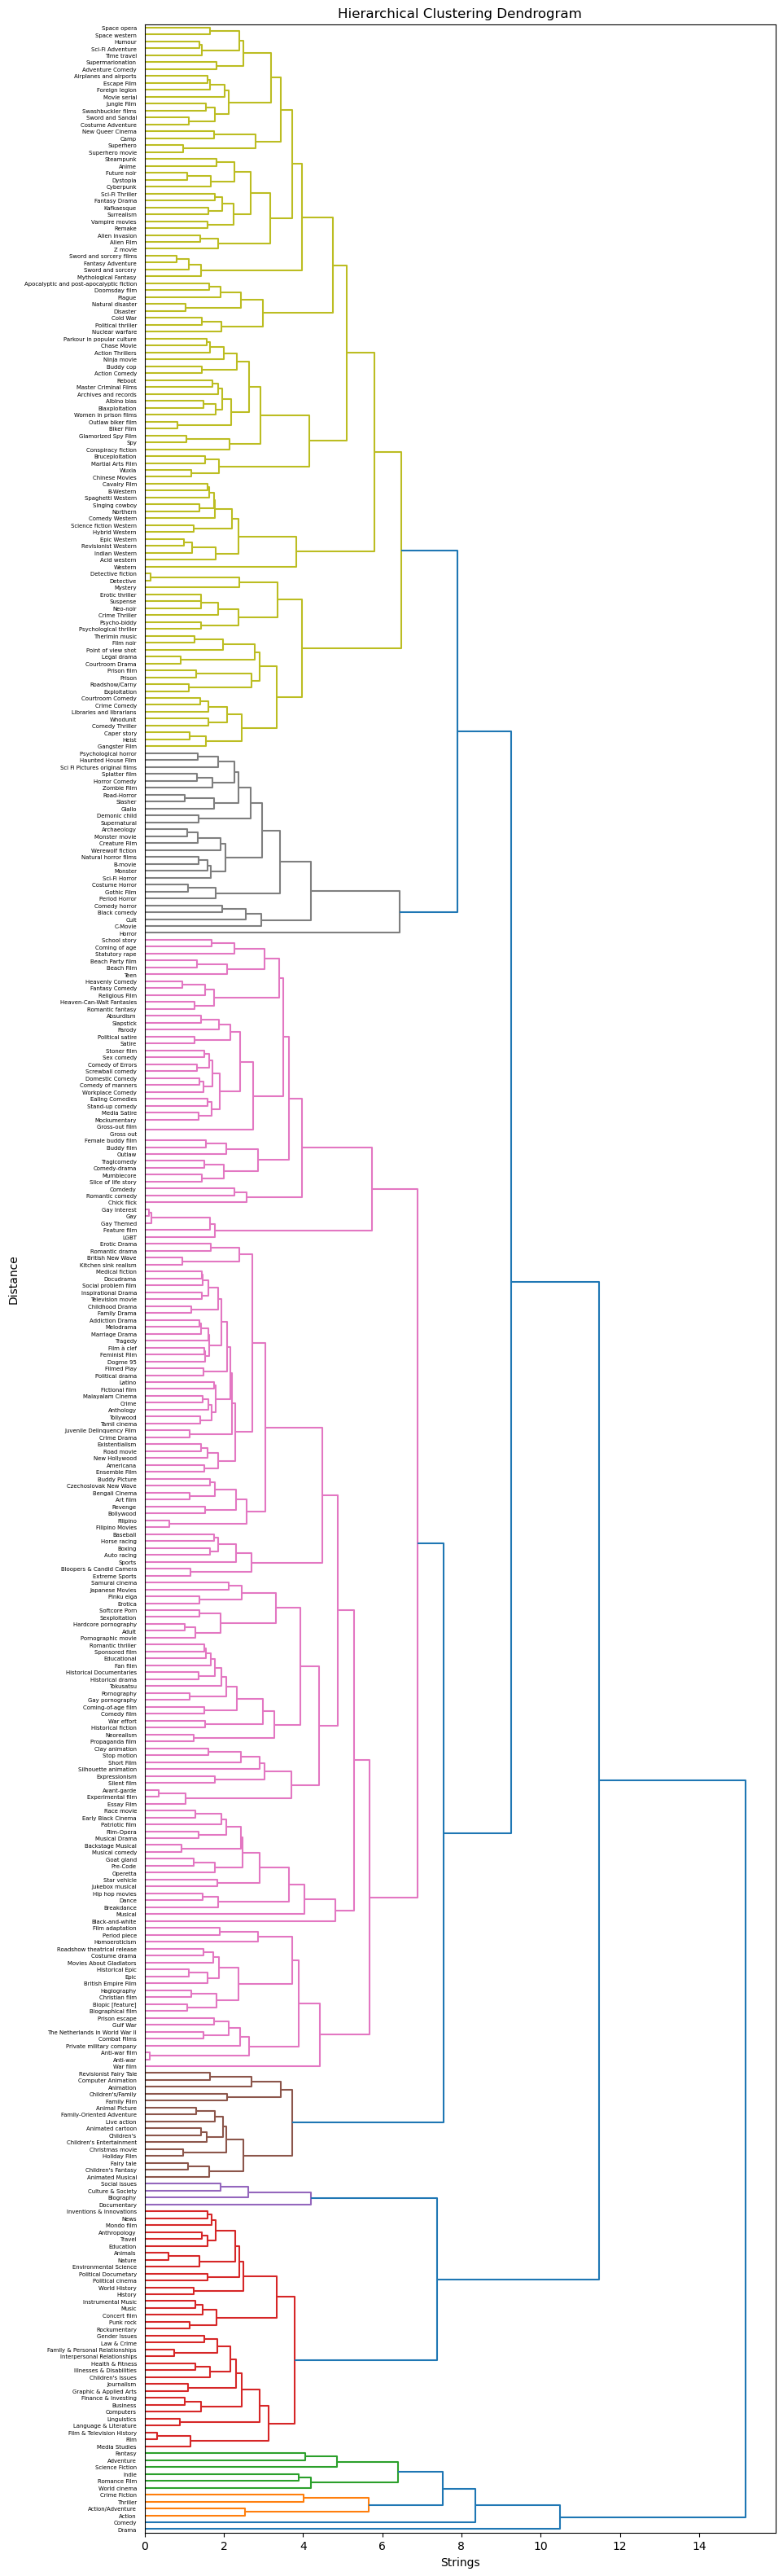

In [26]:
total_occurences_naive = (
    movie["Movie_genres"]
    .apply(lambda x: pd.Series(x).value_counts())
    .sum()
    .sort_values(ascending=False)
)
co_occurrence_matrix_naive = pd.DataFrame(
    0, columns=total_occurences_naive.index, index=total_occurences_naive.index
)

# Fill in the co-occurrence matrix
for sublist in movie["Movie_genres"].dropna():
    for i in range(len(sublist)):
        co_occurrence_matrix_naive.at[sublist[i], sublist[i]] += 1
        for j in range(i + 1, len(sublist)):
            string1, string2 = sublist[i], sublist[j]
            co_occurrence_matrix_naive.at[string1, string2] += 1
            co_occurrence_matrix_naive.at[string2, string1] += 1

for i in total_occurences_naive.index:
    for j in total_occurences_naive.index:
        co_occurrence_matrix_naive.at[i, j] = co_occurrence_matrix_naive.at[i, j] / min(
            total_occurences_naive[i], total_occurences_naive[j]
        )

linkage_matrix_naive = linkage(co_occurrence_matrix_naive, method="ward")

plt.figure(figsize=(10, 40))
dendrogram(
    linkage_matrix_naive,
    labels=co_occurrence_matrix_naive.index,
    orientation="right",
    color_threshold=7,
)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Strings")
plt.ylabel("Distance")
plt.show()

We clearly see that this clustering is not doing ia good job, for exemple for the comedy movies where athe different kind of comedies are not gathered together.

### Genres cleaning

We filter the genres by not taking into account the genres with less than 500 movies (1) and by gathering the other into 30 custom main genres thanks to the `clean_genres` function and `categorized_genres` mapping dictionnary available in the `src/genres_analysis.py` file. 

NB: This mapping dictionnary has been set such that one initial genres may split in two custom main genres, for exemple "Romantic Comedy" will appear in "Romance" and "Comedy"

(1) As shown below, omit these genres does not really affect the number of movies withe genre(s) (at least one)

In [27]:
from src.genres_analysis import clean_genres, CATEGORIZED_GENRES

movie["Movie_clean_genres"] = (
    movie["Movie_genres"].dropna().apply(lambda x: clean_genres(x, CATEGORIZED_GENRES))
)

In [28]:
len(movie["Movie_clean_genres"].dropna())

78715

In [29]:
len(movie["Movie_genres"].dropna())

79447

The number of film with clean genres is not significantly lower than the number of film with initial genres. Therefore the `categorized_genres` mapping dictionnary did great.

### Genres clustering

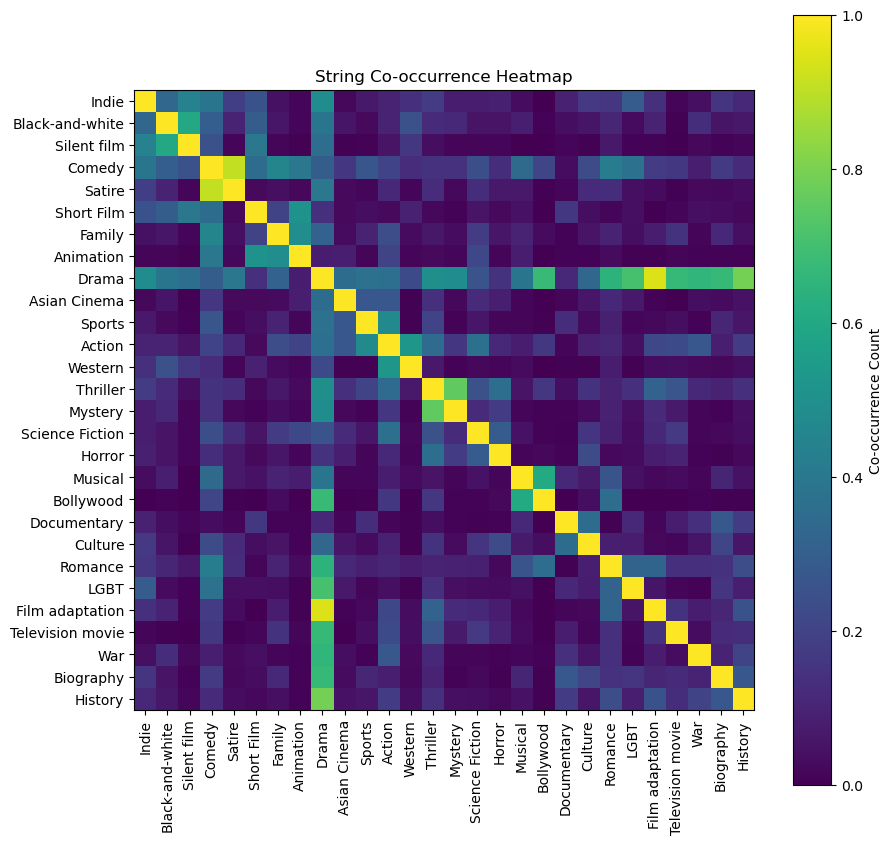

In [30]:
total_occurences = (
    movie["Movie_clean_genres"]
    .apply(lambda x: pd.Series(x).value_counts())
    .sum()
    .sort_values(ascending=False)
)
co_occurrence_matrix = pd.DataFrame(
    0, columns=total_occurences.index, index=total_occurences.index
)

# Fill in the co-occurrence matrix
for sublist in movie["Movie_clean_genres"].dropna():
    for i in range(len(sublist)):
        co_occurrence_matrix.at[sublist[i], sublist[i]] += 1
        for j in range(i + 1, len(sublist)):
            string1, string2 = sublist[i], sublist[j]
            co_occurrence_matrix.at[string1, string2] += 1
            co_occurrence_matrix.at[string2, string1] += 1

for i in total_occurences.index:
    for j in total_occurences.index:
        co_occurrence_matrix.at[i, j] = co_occurrence_matrix.at[i, j] / min(
            total_occurences[i], total_occurences[j]
        )

linkage_matrix = linkage(co_occurrence_matrix, method="ward")
co_occurrence_matrix_sorted = co_occurrence_matrix.loc[
    co_occurrence_matrix.index[
        dendrogram(linkage_matrix, orientation="right", no_plot=True)["leaves"]
    ],
    :,
]
co_occurrence_matrix_sorted = co_occurrence_matrix_sorted[
    co_occurrence_matrix_sorted.columns[
        dendrogram(linkage_matrix, orientation="bottom", no_plot=True)["leaves"]
    ]
]
co_occurrence_matrix_sorted.values

plt.figure(figsize=(10, 10))
plt.imshow(co_occurrence_matrix_sorted.values, cmap="viridis", interpolation="none")
plt.colorbar(label="Co-occurrence Count")
plt.xticks(
    np.arange(len(total_occurences.index)),
    co_occurrence_matrix_sorted.index,
    rotation=90,
)
plt.yticks(np.arange(len(total_occurences.index)), co_occurrence_matrix_sorted.index)
plt.title("String Co-occurrence Heatmap")
plt.show()

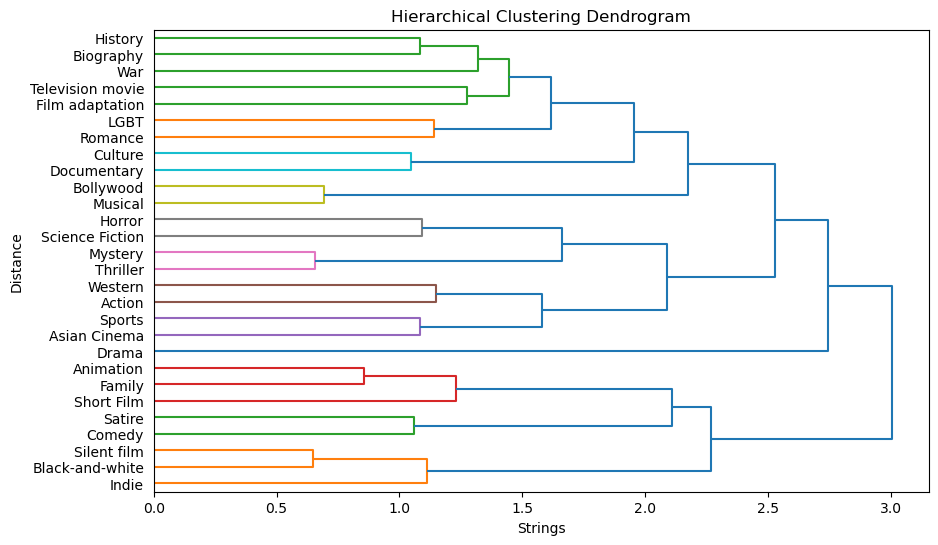

In [31]:
# Plot the dendrogram to visualize hierarchical clustering
plt.figure(figsize=(10, 6))
dendrogram(
    linkage_matrix,
    labels=co_occurrence_matrix.index,
    orientation="right",
    color_threshold=1.5,
)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Strings")
plt.ylabel("Distance")
plt.show()

In [32]:
clusters = fcluster(linkage_matrix, t=1.5, criterion="distance")

In [33]:
# Create a dict to map cluster labels to total_occurences indices
cluster_dict = defaultdict(list)

for i, cluster_number in enumerate(clusters):
    cluster_dict[cluster_number].append(total_occurences.index[i])

cluster_dict = dict(cluster_dict)

print(cluster_dict)

{12: ['Drama'], 2: ['Comedy', 'Satire'], 6: ['Thriller', 'Mystery'], 5: ['Action', 'Western'], 10: ['Romance', 'LGBT'], 1: ['Black-and-white', 'Indie', 'Silent film'], 3: ['Short Film', 'Family', 'Animation'], 9: ['Documentary', 'Culture'], 7: ['Science Fiction', 'Horror'], 8: ['Musical', 'Bollywood'], 4: ['Asian Cinema', 'Sports'], 11: ['Biography', 'History', 'War', 'Film adaptation', 'Television movie']}


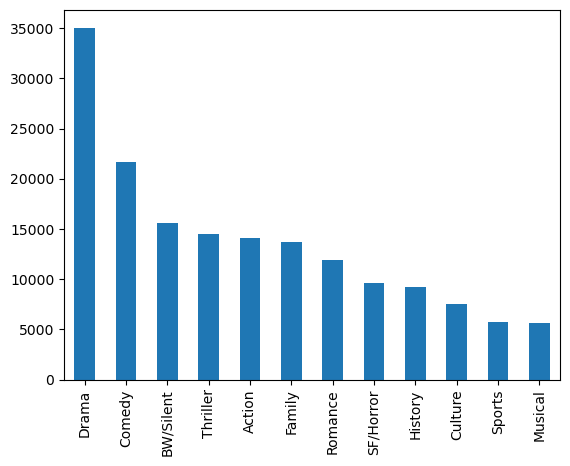

In [34]:
cluster_keys = [
    "Drama",
    "Comedy",
    "Thriller",
    "Action",
    "Romance",
    "BW/Silent",
    "Family",
    "Culture",
    "SF/Horror",
    "Musical",
    "Sports",
    "History",
]
genres_dict = dict(zip(cluster_keys, list(cluster_dict.values())))

movie["Movie_main_genres"] = (
    movie["Movie_clean_genres"].dropna().apply(lambda x: clean_genres(x, genres_dict))
)

main_genre_occ = (
    movie["Movie_main_genres"]
    .apply(lambda x: pd.Series(x).value_counts())
    .sum()
    .sort_values(ascending=False)
)

main_genre_occ.plot(kind="bar")

In [35]:
def sorted_main_genres(item):
    return list(main_genre_occ.index).index(item)


# In order to have the main genre, the second genre, etc...
movie["Movie_main_genres"] = (
    movie["Movie_main_genres"]
    .dropna()
    .apply(lambda x: sorted(x, key=sorted_main_genres))
)